In [ ]:
# importing
from tensorflow import keras
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.patches as patches


## 1. Loading Information

In [ ]:
# loading the mnist data

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# exploring shapes of train and test data

print('shape of train dataset is',np.shape(x_train))
print('shape of test dataset is',np.shape(x_test))

shape of train dataset is (60000, 28, 28)
shape of test dataset is (10000, 28, 28)


In [ ]:
# a function that creates an image with mnist digit randomly placed in it and prepearing the dataset

def create_big_img(images_data, images_labels, img_size):

  dataset = dict()
  dataset["class_name"] = list()
  dataset["top_x"] = list()
  dataset["top_y"] = list()
  dataset["bottom_x"] = list()
  dataset["bottom_y"] = list()

  new_images = np.zeros((len(images_data), img_size, img_size))
  for i in range(0, len(images_data)):
    
    img = images_data[i, :, :]
    h, w = img.shape[0], img.shape[1]
    bigger_img = np.zeros((img_size,img_size))
    x = np.random.randint(0, img_size-1-img.shape[0]) # top left column of the image
    y = np.random.randint(0, img_size-1-img.shape[0]) # top left row of the image
    bigger_img[y:y+img.shape[0], x:x+img.shape[0]] = img # placing the digit in the bigger image

    new_images[i, :, :] = bigger_img

    dataset["top_x"].append(x/img_size)
    dataset["top_y"].append(y/img_size)
    dataset["bottom_x"].append((x+w)/img_size)
    dataset["bottom_y"].append((y+h)/img_size)
    dataset["class_name"].append(images_labels[i])
  images_dataframe = pd.DataFrame(dataset)
    

  return new_images, images_dataframe

In [ ]:
# impementing the function (creating images of sizes 50X50) 

bigger_images_train, train_data = create_big_img(x_train,y_train, 50)
bigger_images_test, test_data = create_big_img(x_test,y_test, 50)


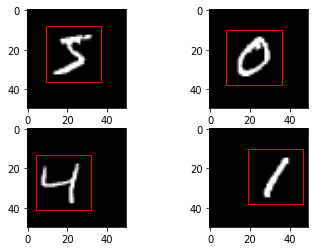

In [ ]:
# plotting a few examples

fig, ax = plt.subplots(2,2)
ax[0,0].imshow(bigger_images_train[0], cmap='gray')
ax[0,0].add_patch(patches.Rectangle((train_data["top_x"][0]*50,train_data["top_y"][0]*50), 28, 28, linewidth=1, edgecolor='r', facecolor='none'))
ax[0,1].imshow(bigger_images_train[1], cmap='gray')
ax[0,1].add_patch(patches.Rectangle((train_data["top_x"][1]*50,train_data["top_y"][1]*50), 28, 28, linewidth=1, edgecolor='r', facecolor='none'))
ax[1,0].imshow(bigger_images_train[2], cmap='gray')
ax[1,0].add_patch(patches.Rectangle((train_data["top_x"][2]*50,train_data["top_y"][2]*50), 28, 28, linewidth=1, edgecolor='r', facecolor='none'))
ax[1,1].imshow(bigger_images_train[3], cmap='gray')
ax[1,1].add_patch(patches.Rectangle((train_data["top_x"][3]*50,train_data["top_y"][3]*50), 28, 28, linewidth=1, edgecolor='r', facecolor='none'))
plt.show()

## 2. Network

In [ ]:
# expanding dimension of datasets
x_train_final = np.expand_dims(bigger_images_train, -1)
x_test_final = np.expand_dims(bigger_images_test, -1)

print('the shape of train dataset is:',x_train_final.shape)
print('the shape of test dataset is:',x_test_final.shape)


the shape of train dataset is: (60000, 50, 50, 1)
the shape of test dataset is: (10000, 50, 50, 1)


In [ ]:
# convert class to binary 
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
# prepearing targets (a list with label of the digit and with the bounding box data)
train_targets = ([y_train,np.transpose(np.array([train_data["top_x"], train_data["top_y"], train_data["bottom_x"], train_data["bottom_y"]]))])
test_targets = ([y_test,np.transpose(np.array([test_data["top_x"], test_data["top_y"], test_data["bottom_x"], test_data["bottom_y"]]))])

In [ ]:
# a function that builds the model 
def get_model():
    inputs = keras.layers.Input(shape=(50,50,1))
    x = keras.layers. Conv2D(32, kernel_size=5, activation="relu")(inputs)
    x = keras.layers.MaxPooling2D(pool_size=2)(x)
    x = keras.layers.Conv2D(64, kernel_size=5, activation='relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=2)(x)
    x = keras.layers.Flatten()(x)
    
    classifier_head = keras.layers.Dropout(0.2)(x)
    classifier_head = keras.layers.Dense(10, activation='softmax', name='classifier')(classifier_head)

    reg_head = keras.layers.Dense(64, activation='relu')(x)
    reg_head = keras.layers.Dense(32, activation='relu')(reg_head)
    reg_head = keras.layers.Dense(4, activation='sigmoid', name='bbox')(reg_head) 

    return keras.Model(inputs=[inputs], outputs=[classifier_head, reg_head])


In [ ]:
# define the model 
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 46, 46, 32)   832         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 23, 23, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 19, 19, 64)   51264       ['max_pooling2d[0][0]']          
                                                                                              

In [ ]:
# compiling the model
model.compile(optimizer='adam', 
              loss={'classifier': 'categorical_crossentropy', 'bbox': 'mse'}, 
              metrics={'classifier':'acc', 'bbox': 'mse'})



In [ ]:
# fitting the model
batch_size = 100
model.fit(x_train_final, train_targets, batch_size=batch_size, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
480/480 [==============================] - 230s 478ms/step - loss: 1.1912 - classifier_loss: 1.1866 - bbox_loss: 0.0046 - classifier_acc: 0.6775 - bbox_mse: 0.0046 - val_loss: 0.2737 - val_classifier_loss: 0.2729 - val_bbox_loss: 8.0325e-04 - val_classifier_acc: 0.9208 - val_bbox_mse: 8.0325e-04
Epoch 2/10
480/480 [==============================] - 214s 446ms/step - loss: 0.2806 - classifier_loss: 0.2799 - bbox_loss: 6.4949e-04 - classifier_acc: 0.9136 - bbox_mse: 6.4949e-04 - val_loss: 0.1835 - val_classifier_loss: 0.1829 - val_bbox_loss: 5.6992e-04 - val_classifier_acc: 0.9460 - val_bbox_mse: 5.6992e-04
Epoch 3/10
480/480 [==============================] - 215s 447ms/step - loss: 0.2045 - classifier_loss: 0.2040 - bbox_loss: 4.8666e-04 - classifier_acc: 0.9361 - bbox_mse: 4.8666e-04 - val_loss: 0.2007 - val_classifier_loss: 0.2002 - val_bbox_loss: 4.7285e-04 - val_classifier_acc: 0.9445 - val_bbox_mse: 4.7285e-04
Epoch 4/10
480/480 [==============================] - 215s 4

2b. In this section I built an object locaization network including convolutional neural network with 
2 convolutional layers, 2 pooling layers, a dropout layer (to avoid over fitting), and a fully connected layer.In addition, the network has 2 heads, as seen in the image below.

The first head is the classifier head, that predicts the digit itself and the second head is a regression head that predicts the bounding box (it predicts the top left point and the bottom right point of the bounding box).  

Another alternative that I could use was to build an object detection network such as RCNN. 

Another concern was which parameters to use in each layer of the network. 

Finally, the network ran on the train set, with a validation set of 20% that was taken from the train set. 


# 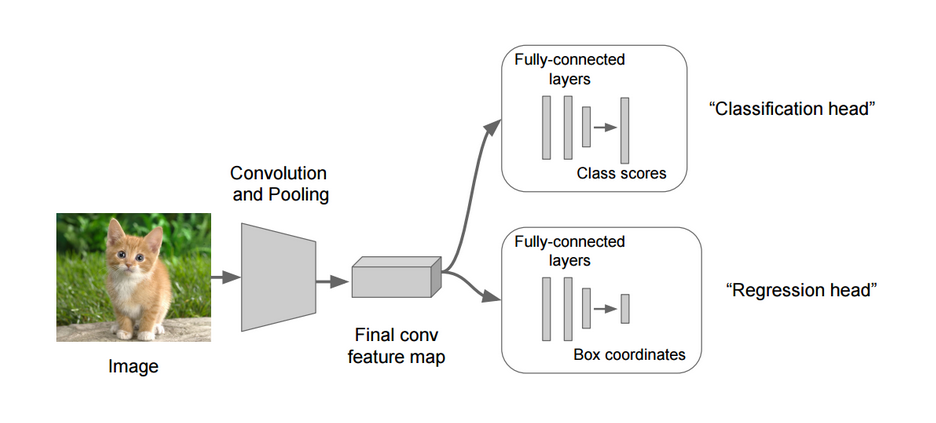

>



## 3. Performance Analysis

a1. The following function is ment to examine the performance of the network. 
The function takes the test set and the test labels and returns the loss and the accuracy of the model for the classification head and for the regression head. In addition, I chose to present a confusion matrix to see which digits the network is more or less successful in predicting. 
You can also see a section that plots an example of one of the images in the test set with its prediction (classification and bounding box prediction). 

In [ ]:
# a function that calculates the performance of the network
def net_performance(test_set, test_labels, net_model):

  # evaluating the model on the test set
  [loss, classifier_loss, reg_loss, classifier_acc, reg_mes] = net_model.evaluate(test_set, test_labels)

  # creating a confusion matrix from the predictions of the classifier 
  predictions = model.predict(x_test_final)
  y_pred = (predictions[0] > 0.5)
  
  cm = np.round(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='true'),2) 
  disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
  disp.plot(cmap='hot')
  plt.show()

  

313/313 [==============================] - 13s 39ms/step - loss: 0.0972 - classifier_loss: 0.0970 - bbox_loss: 2.5889e-04 - classifier_acc: 0.9727 - bbox_mse: 2.5889e-04


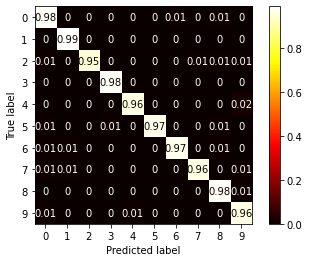

In [ ]:
# implementing the performance analysis function on the test set 
net_performance(x_test_final, test_targets, model)

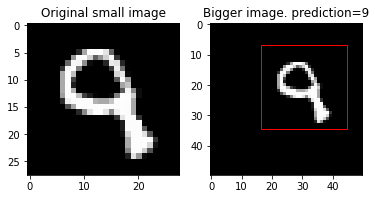

In [ ]:
# example of the results - showing the results for one of the images from the test set

image_num = 4000
# The classification of the digit 
predictions = model.predict(x_test_final)
y_pred = (predictions[0] > 0.5)
y_pred_image = y_pred[image_num]
y_pred_image = np.where(y_pred_image==True)[0][0]

# The bounding box
image_bbox = predictions[1][image_num]

# plotting
image_example = x_test_final[image_num , :, :, 0]
fig, ax = plt.subplots(1,2)
ax[0].imshow(x_test[image_num], cmap='gray')
ax[0].title.set_text('Original small image')
ax[1].imshow(image_example, cmap='gray')
ax[1].add_patch(patches.Rectangle((image_bbox[0]*50, image_bbox[1]*50), 50*(image_bbox[2]-image_bbox[0]), 50*(image_bbox[3]-image_bbox[1]), linewidth=1, edgecolor='r', facecolor='none'))
ax[1].title.set_text('Bigger image. prediction='+str(y_pred_image))
plt.show()



b1. In the following section, I made changes in the images that included flipping the image left-right, up-down and rotating it 90 degrees.  I chose to use these changes because I wanted to see if the network can classify correctly the digits although they don't necessarily look like themselves. 
After observing the results, I saw that the performance of the model decreased.

The deamage to the netwotk was most present in the training and validation data sets , although the performance of the model on the test set also decreased.


In [ ]:
# data augmentation - randomly flip left right, flip up down, rot90 

x_train_aug = x_train_final.copy()

nums_flip_left_right = np.random.randint(0,len(x_train_aug), 10000, dtype=int)
nums_flip_up_down = np.random.randint(0,len(x_train_aug), 10000, dtype=int)
nums_rot90 = np.random.randint(0,len(x_train_aug), 10000, dtype=int)

x_train_aug[nums_flip_left_right] = np.array(list(map(tf.image.flip_left_right, x_train_aug[nums_flip_left_right])))
x_train_aug[nums_flip_up_down] = np.array(list(map(tf.image.flip_up_down, x_train_aug[nums_flip_up_down])))
x_train_aug[nums_rot90] = np.array(list(map(tf.image.rot90, x_train_aug[nums_rot90])))



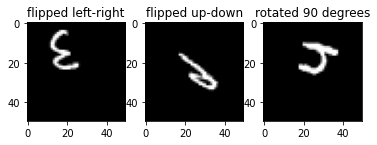

In [ ]:
# plotting a few examples of the augmented data

fig,ax = plt.subplots(1, 3)
ax[0].imshow(x_train_aug[nums_flip_left_right[400],:,:,0], cmap='gray')
ax[0].title.set_text('flipped left-right')
ax[1].imshow(x_train_aug[nums_flip_up_down[9000],:,:,0], cmap='gray')
ax[1].title.set_text('flipped up-down')
ax[2].imshow(x_train_aug[nums_rot90[4500],:,:,0], cmap='gray')
ax[2].title.set_text('rotated 90 degrees')

In [ ]:
# defining and compiling the model

aug_model = get_model()
aug_model.compile(optimizer='adam', 
                  loss={'classifier': 'categorical_crossentropy', 'bbox': 'mse'}, 
                  metrics={'classifier':'acc', 'bbox': 'mse'})

In [ ]:
# fitting the model on the augmented data
batch_size = 100
aug_model.fit(x_train_aug, train_targets, batch_size=batch_size, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
480/480 [==============================] - 219s 455ms/step - loss: 1.8526 - classifier_loss: 1.8401 - bbox_loss: 0.0125 - classifier_acc: 0.4476 - bbox_mse: 0.0125 - val_loss: 1.0586 - val_classifier_loss: 1.0499 - val_bbox_loss: 0.0087 - val_classifier_acc: 0.6743 - val_bbox_mse: 0.0087
Epoch 2/10
480/480 [==============================] - 221s 461ms/step - loss: 0.9778 - classifier_loss: 0.9700 - bbox_loss: 0.0078 - classifier_acc: 0.6914 - bbox_mse: 0.0078 - val_loss: 0.7619 - val_classifier_loss: 0.7546 - val_bbox_loss: 0.0073 - val_classifier_acc: 0.7619 - val_bbox_mse: 0.0073
Epoch 3/10
480/480 [==============================] - 236s 493ms/step - loss: 0.7634 - classifier_loss: 0.7564 - bbox_loss: 0.0069 - classifier_acc: 0.7544 - bbox_mse: 0.0069 - val_loss: 0.6414 - val_classifier_loss: 0.6344 - val_bbox_loss: 0.0069 - val_classifier_acc: 0.7938 - val_bbox_mse: 0.0069
Epoch 4/10
480/480 [==============================] - 222s 462ms/step - loss: 0.6657 - classifier_lo

313/313 [==============================] - 12s 38ms/step - loss: 0.1798 - classifier_loss: 0.1779 - bbox_loss: 0.0019 - classifier_acc: 0.9459 - bbox_mse: 0.0019


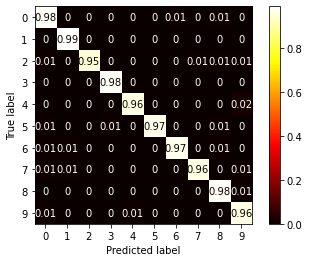

In [ ]:
# implementing the performance analysis function on the test set after training on the augmented data
net_performance(x_test_final, test_targets, aug_model)

c. I think that there are a lot of ways to improve the network. First, after seeing the results of the model on augmented data, I believe that a pre-step of registration could be beneficial in order to fix different rotations of the images. In addition, maybe using more epochs can improve the model performance. Overall, maybe passing different parameters to the model could improve the model performance. I would implement it using a step of hyper-parameter tuning and I would also add a step of cross validation. 
Moreover, maybe using RCNN network that first offeres regions on interest can have better performance.